In [1]:
!pip install stable_baselines==2.10.0
!pip install celluloid
!pip install tqdm

In [2]:
%tensorflow_version 1.x
import numpy as np
import tensorflow as tf
import gym
from gym import spaces
import copy


from stable_baselines.common.policies import *
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import *

TensorFlow 1.x selected.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [0]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from celluloid import Camera

In [0]:
assert tf.version.VERSION[0] == '1'

In [5]:
import stable_baselines
stable_baselines.__version__

'2.10.0'

## Area

In [0]:
class Area:
    def __init__(self, dummy_agent_count=False, size=100, threshold=0.6, border_width=2, border_val=-3):
        self.size = size
        self.threshold = threshold
        self.border_width = border_width
        self.border_val = border_val
        self.area = self.__generate_area()
        self.character_space = np.empty((self.area).shape, dtype=object) # 
        self.dummy_agent_count = dummy_agent_count
        if self.dummy_agent_count:
            dummy_agent_mask = np.random.random(size=[self.size, self.size]) < size/dummy_agent_count**2.
            low = self.border_width
            up = self.border_width + self.size
            self.character_space[low:up, low:up][dummy_agent_mask] = 1
        
            
    def reset(self):
        self.area = self.__generate_area()
        self.character_space = np.empty((test_area.area).shape, dtype=object) # 
    
    def visualize_character_space(self):
        return np.array(self.character_space != None, dtype=np.int)
    
    def get_random_pos(self):
        low = self.border_width
        high = self.size + self.border_width
        pos_arr = np.random.randint(low, high, size=(2,))
        return tuple(pos_arr)
    
    def area_update_pos(self, old_pos, new_pos, agent):
        self.character_space[old_pos] = None
        self.character_space[new_pos] = agent
        if self.dummy_agent_count:
            self.update_dummy_agents()
    
    def update_dummy_agents(self):
        pos = []
        for ri in range(len(self.character_space)):
            for ci in range(len(self.character_space)):
                if self.character_space[ri][ci] == 1:
                    self.character_space[ri][ci] = None
                    pos.append([ri,ci])
        for p in pos:
            axis = np.random.randint(2)
            move = np.random.randint(2)
            p[axis] += [-1,1][move]
            if p[0] > self.border_width and p[0] < self.size and p[1] > self.border_width and p[1] < self.size:
                self.character_space[p[0]][p[1]] = p
    
    def __generate_area(self):
        border_row = np.array([[self.border_val for i in range(self.size + 2*self.border_width)]])
        border = np.repeat(border_row, self.border_width, axis=0)
        init_area = border

        for i in range(self.size):
            row = (np.random.rand(self.size) > self.threshold).astype(int) * 3
            for i in range(self.border_width):
                row = np.insert(row, 0, self.border_val)
                row = np.append(row, self.border_val)
            init_area = np.concatenate((init_area, [row]))

        init_area = np.concatenate((init_area, border))

        return init_area

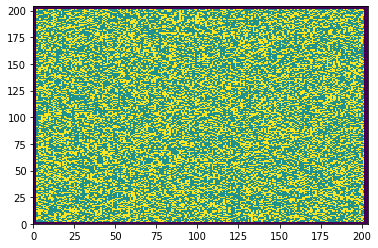

In [7]:
test_area = Area(size=200)

plt.pcolor(test_area.area)

## Agent

In [0]:
class Agent(gym.Env):
    
    def __init__(self, area):
        self.area = area
        self.reward_rangee = (0, 3)
        self.action_space = spaces.Discrete(6)
        self.observation_space = self.init_observation_space()
        self.position = self.area.get_random_pos()
        
    def reset(self, position=None, train=True):
        if not position:
            position = self.area.get_random_pos()
        self.fitness = 10
        self.update_position(position)
        self.reward_sum = 0
        if train:
            self.area.reset()
        
        return self._next_observation()
    
    def update_position(self, position):
        # print(self.area.visualize_character_space())
        self.area.area_update_pos(self.position, position, self)
        self.position = position
        
    def init_observation_space(self):
        map_ = [3 for i in range(25)] 
        actors = [2 for i in range(25)]
        nvec = map_ + actors
        return spaces.MultiDiscrete(nvec=nvec)
    
    def _next_observation(self):
        x, y = self.position
        visible_map = self.area.area[x-2:x+3, y-2:y+3]
        visible_actors = self.area.visualize_character_space()[x-2:x+3, y-2:y+3]
        visible = np.concatenate([visible_map.flatten(), visible_actors.flatten()])
        return visible
    
    def step(self, action, test=False):
        
        reward = 0
        x, y = self.position
        
        if action < 4:
            if action == 0:
                new_y = y-1 if y>self.area.border_width else y
                position = x, new_y
            if action == 1: 
                new_y = y+1 if y<self.area.size + self.area.border_width - 1 else y
                position = x, new_y
            if action == 2:
                new_x = x+1 if x<self.area.size + self.area.border_width - 1 else x
                position = new_x, y
            if action == 3:
                new_x = x-1 if x>self.area.border_width else x
                position = new_x, y
            if self.area.visualize_character_space()[position] == 0:
                self.update_position(position)
            x, y = self.position
            self.fitness -= 1
        elif action == 4:
            if self.area.area[x, y] == 3:
                self.reward_sum += 6
                self.fitness += 6
                reward = 6
                self.area.area[x, y] = 0
            else:
                self.fitness -= 1
        else: 
            if self.fitness >= 2 and np.sum(self.area.visualize_character_space()[x-1:x+2, y-1:y+2]) > 1:
                self.reward_sum += 16
                self.fitness -= 2
                reward = 16
                if test:
                    directions = np.array([[-1,0], [0,1],[1,0],[0,-1]])
                    direction_values = self.area.visualize_character_space()[x-1:x+2, y-1:y+2][[0,1,1,2],[1,0,2,1]] 
                    for mv,d in zip(directions, direction_values):
                        if d == 0:
                            x, y = np.array([x,y]) + mv
                            x_ok = x>self.area.border_width and x<self.area.size + self.area.border_width - 1
                            y_ok = y>self.area.border_width and y<self.area.size + self.area.border_width - 1
                            if(x_ok and y_ok):
                                spawn_new(x, y)
                                break
                    #spawn_new(x, y)
            else:
                self.fitness -= 1
                
        
        done = self.fitness <= 0
        
        obs = self._next_observation()
        
        return obs, reward, done, {}
    
    def render(self, mode='human', close=False):
        x, y = self.position
        # print(self.__hash__(), ":  ", self.reward_sum)
        return x, y

## Model

In [9]:
agent_count = 800
area_size = 200
area = Area(dummy_agent_count=agent_count, size=area_size)
model = A2C(MlpPolicy, Agent(area), verbose=0)
model.learn(total_timesteps=25000)





Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor




## Simulation

In [0]:
# env1 = Agent(area)
# env2 = Agent(area)
envs = [Agent(area) for i in range(agent_count)]
#envs = [env1, env2]
env_obs = {}

stored_maps = []
to_spawn = []

def spawn_new(x, y):
    to_spawn.append((x,y))

for env in envs:
    obs = env.reset(train=False)
    env_obs[env] = obs

for i in range(200):
    copied_map = np.copy(area.area)
    
    for x, y in to_spawn:
        new_env = Agent(area)
        obs = new_env.reset(position=(x, y), train=False)
        action, _states = model.predict(obs)
        obs, rewards, done, info = env.step(action, test=True)
        envs.append(new_env)
        env_obs[new_env] = obs
        # print("New joined!")
        x, y = new_env.render()
    to_spawn.clear()
    
    for idx, env in enumerate(envs):
        obs = env_obs[env]
        action, _states = model.predict(obs)
        obs, rewards, done, info = env.step(action, test=True)
        env_obs[env] = obs
        x, y = env.render()
        copied_map[x,y] = -2
        if done:
            envs.pop(idx)
        
    stored_maps.append(copied_map)

In [0]:
from tqdm import tqdm

100%|██████████| 200/200 [01:44<00:00,  1.91it/s]


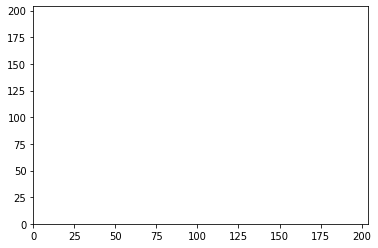

In [12]:
fig = plt.figure()
camera = Camera(fig)
for i in tqdm(range(200)):
    plt.pcolor(stored_maps[i])
    camera.snap()
animation = camera.animate()
animation.save('sim_final_200_4.mp4')